In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.lib import solve_2d_ode_spectral
from pywave.energy_transport.energy_transfer_2dirns import EnergyTransfer2Dirns

In [2]:
class ET2dirnsManager(EnergyTransfer2Dirns):
    def __init__(self, dx, dt, cg, u_l=1,
                 reflection_coefficient=1,
                 alpha=.1,
                 gamma=0,
                 nx=100,
                 nt=50,
                 outdir=None,
                 **kwargs):
        super().__init__(dx, dt, **kwargs)
        self.nx = nx
        self.nt = nt
        self.x = np.arange(nx, dtype=float)*dx
        self.u_l = u_l
        self.outdir = outdir
        self.set_init_cons()
        self.set_scattering_props(alpha, gamma, cg)
        self.set_steady_cons(alpha, gamma, reflection_coefficient)


    def set_init_cons(self):
        self.u0 = np.full_like(self.x, self.u_l)
        self.u0[self.x>self.x[self.nx//3]] = 0
        self.v0 = np.zeros_like(self.x)
        self.u = self.u0.copy()
        self.v = self.v0.copy()


    def set_scattering_props(self, alpha, gamma, cg):
        self.scattering_mask = np.zeros_like(self.x)
        self.scattering_mask[self.x>self.x[self.nx//2]] = 1.
        self.alpha = alpha*self.scattering_mask
        self.gamma = gamma*self.scattering_mask
        self.cg = np.full_like(self.x, cg)
        
        
    def set_steady_cons(self, alpha, gamma, reflection_coefficient):
        a, b, c, d = self.get_source_matrix(alpha, gamma, shape=(1,))
        dcg = np.gradient(self.cg)/self.dx
        abcd = [arr/self.cg[0] for arr in (a - dcg[0], b, -c, dcg[0] - d)]
        u0 = np.array([self.u_l])
        v0 = reflection_coefficient*u0
        self.u_steady = np.full_like(self.x, u0[0])
        self.v_steady = np.full_like(self.x, v0[0])
        wh = np.where(self.scattering_mask==1.)
        x = self.x[wh]
        self.u_steady[wh], self.v_steady[wh] = (
            arr.flatten() for arr in solve_2d_ode_spectral(u0, v0, x-x[0], *abcd))


    def plot_step(self, n):
        plt.close()
        fig, axes = plt.subplots(
            nrows=3, ncols=1, sharex=True, squeeze=True)
        for ax, arr, arr_steady, ylabel in zip(
                axes,
                [self.u, self.v, self.u + self.v],
                [self.u_steady, self.v_steady, self.u_steady + self.v_steady],
                ["$E_+$", "$E_-$", "E_+ + E_-"],
                ):
            ax.plot(self.x, arr_steady, 'r')
            ax.plot(self.x, arr, '--')
            ax.set_ylabel(ylabel)
            ax.set_yscale('log')
            ax.set_ylim([1e-4, 3])
            ttl = "t=%5.3f" %(n*self.dt)
        axes[0].set_title(ttl)
        axes[-1].set_xlabel("x, m")
        if self.outdir is None: return
        os.makedirs(self.outdir, exist_ok=True)
        figname = os.path.join(self.outdir, 'et2d_%3.3i.png' %n)
        plt.savefig(figname)


    def run(self, reps=10):
        if self.outdir is not None:
            print(f"Saving figs in {self.outdir}")
        for n in range(1, self.nt+1):
            self.u, self.v = self.step(self.u, self.v, self.cg, self.alpha, self.gamma)
            if n%reps != 0: continue
            print(f"Plotting step {n} out of {self.nt}")
            self.plot_step(n)

In [3]:
cfl = .9
dx = 1
dt = 1
alpha = 5e-2
gamma = 0
cg = cfl*dx/dt
refl = 1

# Anisotropic scattering

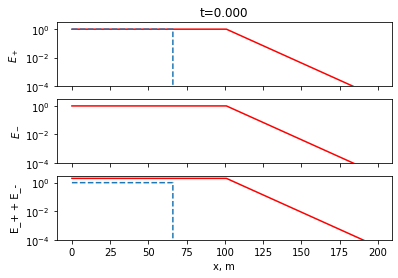

In [4]:
# no dissipation
# - implicit solver with smaller time step
et2d = ET2dirnsManager(
    dx, dt/10, cg, u_l=1,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma,
    nx=200,
    nt=10000,
    outdir="figs_aniso_implicit",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="implicit",
)
et2d.plot_step(0)

In [5]:
# check steady solution
print(
    et2d.u_steady[101:121], 
    np.exp((-2*alpha/cg)*np.arange(20)*dx),
    sep='\n'
)

[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]
[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]


Saving figs in figs_aniso_implicit
Plotting step 50 out of 10000
Plotting step 100 out of 10000
Plotting step 150 out of 10000
Plotting step 200 out of 10000
Plotting step 250 out of 10000
Plotting step 300 out of 10000
Plotting step 350 out of 10000
Plotting step 400 out of 10000
Plotting step 450 out of 10000
Plotting step 500 out of 10000
Plotting step 550 out of 10000
Plotting step 600 out of 10000
Plotting step 650 out of 10000
Plotting step 700 out of 10000
Plotting step 750 out of 10000
Plotting step 800 out of 10000
Plotting step 850 out of 10000
Plotting step 900 out of 10000
Plotting step 950 out of 10000
Plotting step 1000 out of 10000
Plotting step 1050 out of 10000
Plotting step 1100 out of 10000
Plotting step 1150 out of 10000
Plotting step 1200 out of 10000
Plotting step 1250 out of 10000
Plotting step 1300 out of 10000
Plotting step 1350 out of 10000
Plotting step 1400 out of 10000
Plotting step 1450 out of 10000
Plotting step 1500 out of 10000
Plotting step 1550 out of

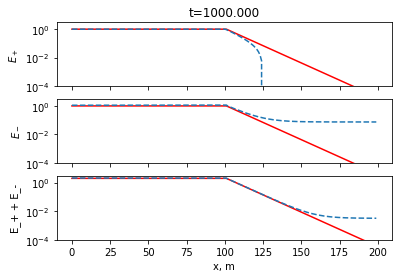

In [6]:
et2d.run(reps=50)

Saving figs in figs_aniso_split
Plotting step 10 out of 2000
Plotting step 20 out of 2000
Plotting step 30 out of 2000
Plotting step 40 out of 2000
Plotting step 50 out of 2000
Plotting step 60 out of 2000
Plotting step 70 out of 2000
Plotting step 80 out of 2000
Plotting step 90 out of 2000
Plotting step 100 out of 2000
Plotting step 110 out of 2000
Plotting step 120 out of 2000
Plotting step 130 out of 2000
Plotting step 140 out of 2000
Plotting step 150 out of 2000
Plotting step 160 out of 2000
Plotting step 170 out of 2000
Plotting step 180 out of 2000
Plotting step 190 out of 2000
Plotting step 200 out of 2000
Plotting step 210 out of 2000
Plotting step 220 out of 2000
Plotting step 230 out of 2000
Plotting step 240 out of 2000
Plotting step 250 out of 2000
Plotting step 260 out of 2000
Plotting step 270 out of 2000


/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Plotting step 280 out of 2000


/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/pywave/pywave/energy_transport/flux_limiters.py:40: RuntimeWarning: overflow encountered in multiply
  vector_min(1, 2*r), vector_min(r, 2)
/pywave/pywave/energy_transport/lib.py:43: RuntimeWarning: overflow encountered in subtract
  return .5*(u+v - np.abs(u-v))
/pywave/pywave/energy_transport/lib.py:59: RuntimeWarning: invalid value encountered in subtract
  return .5*(u+v + np.abs(u-v))
/pywave/pywave/energy_transport/lib.py:275: RuntimeWarning: overflow encountered in multiply


Plotting step 290 out of 2000
Plotting step 300 out of 2000
Plotting step 310 out of 2000
Plotting step 320 out of 2000
Plotting step 330 out of 2000
Plotting step 340 out of 2000
Plotting step 350 out of 2000
Plotting step 360 out of 2000
Plotting step 370 out of 2000
Plotting step 380 out of 2000
Plotting step 390 out of 2000
Plotting step 400 out of 2000
Plotting step 410 out of 2000
Plotting step 420 out of 2000
Plotting step 430 out of 2000
Plotting step 440 out of 2000
Plotting step 450 out of 2000
Plotting step 460 out of 2000
Plotting step 470 out of 2000
Plotting step 480 out of 2000
Plotting step 490 out of 2000
Plotting step 500 out of 2000
Plotting step 510 out of 2000
Plotting step 520 out of 2000
Plotting step 530 out of 2000
Plotting step 540 out of 2000
Plotting step 550 out of 2000
Plotting step 560 out of 2000
Plotting step 570 out of 2000
Plotting step 580 out of 2000
Plotting step 590 out of 2000
Plotting step 600 out of 2000
Plotting step 610 out of 2000
Plotting s

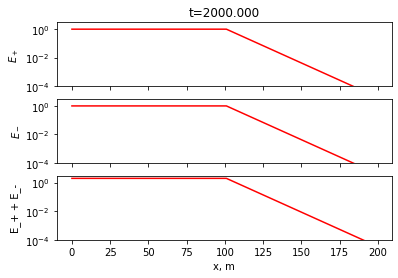

In [7]:
# no dissipation
# - split-step solver with larger time step
# - final results not very sensible
et2d = ET2dirnsManager(
    dx, dt, cg, u_l=1,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma,
    nx=200,
    nt=2000,
    outdir="figs_aniso_split",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="split_step",
)
et2d.plot_step(0)
et2d.run(reps=10)

In [8]:
"""
gamma = 0
uss = np.array([[-1,0],[0,0]])# simple model: u attenuated, no E transferred to v
et = EnergyTransfer2Dirns(dx, dt,
                            unit_scat_source=uss,
                            scheme='first_order_upwind',
                            u_correction_scheme="split_step",
                         )
run(et, u0, v0, c, alpha, gamma, x, outdir='et_fou', **kw_init)
"""

'\ngamma = 0\nuss = np.array([[-1,0],[0,0]])# simple model: u attenuated, no E transferred to v\net = EnergyTransfer2Dirns(dx, dt,\n                            unit_scat_source=uss,\n                            scheme=\'first_order_upwind\',\n                            u_correction_scheme="split_step",\n                         )\nrun(et, u0, v0, c, alpha, gamma, x, outdir=\'et_fou\', **kw_init)\n'